In [1]:
from IPython.display import HTML, clear_output
import sys
sys.path.append("/home/ec2-user/SageMaker/")
import boto3
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta, date
from utils import Athena_Query, s3, LabelStore
from utils.sql_query import SqlQuery

from utils.waveform_viewer2 import Waveform_Chart
from utils.waveform_viewer2 import Waveform_Extract, Waveform_Helper
wh = Waveform_Helper()

athena = Athena_Query()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
hrv = pd.read_csv("s3://hrv-and-others-relationship/features/trauma_final_features/allpatients_hrvdata_problem_new.csv")
#hrv = pd.read_csv("s3://hrv-and-others-relationship/HRV_for_each_onehr/12_hr.csv")
#hrv = hrv.drop(columns=['problemtype'])
hrv.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,patientid,SDNN (ms),SDANN (ms),MeanRR (ms),RMSSD (ms),pNN50 (%),P_VLF (s^2/Hz),P_LF (s^2/Hz),P_HF (s^2/Hz),P_VLF (%),...,Lmean (bts),Lmax (bts),Vmean (bts),Vmax (bts),SD1,SD2,alpha1,alpha2,problemtype,HF/LF
0,A04E1EBC0535DE29A00B2EA348ACDCEF,1327.07,6001.59,282.09,1356.91,0.76,3309.843,3095.212,7033.506,24.629,...,1825.99,3653,1820.00,3640,230.12,861.99,0.20,0.20,MED,2.272727
1,C1EF6CAB75536C2BA0655FF39DA2BB05,1183.60,6141.06,161.35,1194.64,0.22,7982.744,7335.211,15792.172,25.660,...,3205.50,6410,3204.50,6407,473.13,1158.70,0.51,0.57,SUR,2.155172
2,AA06EE2EEEC3006BB4509F21148674A8,14.81,8.96,121.77,122.68,0.00,0.011,0.002,0.002,73.333,...,3642.74,6800,2654.85,4655,0.34,20.69,1.60,1.24,SUR,1.000000
3,46724130B7670EF60E88DCEF22BFB3EB,14.62,14.43,179.30,179.98,0.00,0.004,0.000,0.000,100.000,...,664.19,1161,379.16,567,1.37,19.47,1.46,0.79,MED,NaN
4,F17AFD1A9A5DDE420D6792232A2DF63C,3946.99,399.79,344.84,3962.83,1.02,268175.571,103890.174,113141.276,55.270,...,1224.00,2447,1223.00,2445,1191.43,3256.10,0.75,0.33,MED,1.089325


In [3]:
vital = pd.read_csv("s3://hrv-and-others-relationship/features/trauma_final_features/vital_slope_mean_std_filter_28.csv")
vital.head()

,patientid,HR (mean),Diastolic BP (mean),Systolic BP (mean),ABP Mean (mean),SpO2 (mean),Respiratory rate (mean),HR (slope),Diastolic BP (slope),Systolic BP (slope),ABP Mean (slope),SpO2 (slope),Respiratory rate (slope),HR_std,Diastolic BP_std,Systolic BP_std,ABP Mean_std,SpO2_std,Respiratory rate_std
0,CF654A159982FD3A280A1EB702D5E32E,89.709427,54.529332,122.996831,73.401276,99.684460,19.032981,0.130137,-0.423174,1.344681,-0.094820,-0.017567,0.246270,3.674501,4.558671,11.309684,4.121025,0.526237,1.724865
1,7A428D52AB03B0320865FC9463AD6E24,72.559371,NaN,NaN,NaN,95.432127,23.345642,-1.056293,NaN,NaN,NaN,0.247387,0.161037,4.987653,NaN,NaN,NaN,1.428946,2.422367
2,94DBBFF28CE57A3067A103459227D410,100.952846,71.707114,119.946250,86.904775,99.259423,22.925705,-0.923201,-0.516018,-0.027752,-0.234851,-0.024026,-0.171506,6.658241,3.070629,6.479115,3.087090,0.750736,3.967236
3,C9961BEC4697C5049B2091F84FFAC7DB,61.309293,NaN,NaN,NaN,99.984743,15.762829,-0.124506,NaN,NaN,NaN,-0.000622,-0.200693,3.559009,NaN,NaN,NaN,0.037940,3.335912
4,C5FF715D7605FB1394C025EB578FD8A3,71.234452,65.053117,137.727945,88.685776,99.645125,15.896674,0.484955,-0.277545,0.508155,-0.200911,-0.020944,0.048626,3.823054,2.341800,5.447488,3.491605,0.451994,0.296676


In [4]:
gcs = pd.read_excel("s3://hrv-and-others-relationship/features/trauma_final_features/GCS_new.xlsx")
gcs.rename(columns={'Total_final': 'GCS_final'}, inplace=True)
gcs.head()

,patientid,GCS(eyes)_add,GCS(motor)_add,GCS(verbal)_add,GCS(eyes)_12hr,GCS(motor)_12hr,GCS(verbal)_12hr,GCS(eyes)_final,GCS(motor)_final,GCS(verbal)_final,final from add,Total_add,Total_12hr,GCS_final
0,CF654A159982FD3A280A1EB702D5E32E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7A428D52AB03B0320865FC9463AD6E24,NaN,NaN,NaN,4.0,6.0,5.0,4.0,6.0,5.0,23.0,NaN,15.0,15.0
2,94DBBFF28CE57A3067A103459227D410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C9961BEC4697C5049B2091F84FFAC7DB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AA06EE2EEEC3006BB4509F21148674A8,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,17.0,NaN,3.0,3.0


In [5]:
lab = pd.read_excel("s3://hrv-and-others-relationship/features/trauma_final_features/laboratory data.xlsx")
lab.head()

,patientid,so2,po2,pco2,hemoglobin,carboxyhemoglobin,methemoglobin,chloride,calcium,anion_gap,temperature,potassium,sodium,lactate,glucose
0,CF654A159982FD3A280A1EB702D5E32E,97.0,88.0,35.0,9.3,0.7,0.2,111.0,1.12,2.0,37.1,4.1,138.0,0.8,117.10
1,7A428D52AB03B0320865FC9463AD6E24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,94DBBFF28CE57A3067A103459227D410,97.0,97.0,40.0,10.2,0.3,0.3,114.0,1.11,4.0,37.1,3.5,146.0,1.0,127.91
3,C9961BEC4697C5049B2091F84FFAC7DB,98.0,103.0,44.0,12.6,0.2,0.3,111.0,1.11,2.0,36.1,3.2,137.0,0.7,77.46
4,AA06EE2EEEC3006BB4509F21148674A8,99.0,177.0,37.0,11.2,1.3,0.9,116.0,1.12,8.0,37.5,5.2,140.0,1.7,118.50


In [6]:
# patient_ids = hrv['patientid']
# trauma_age = pd.read_csv("s3://trauma-patient-details/geomatric_lab_data/trauma_age.csv")
# age = trauma_age[trauma_age['patientid'].isin(patient_ids)]
# age.head()

In [7]:
age = pd.read_csv("s3://hrv-and-others-relationship/features/trauma_final_features/geomatric_los.csv")
age['gender'] = age['gender'].replace({'M': 1, 'F': 0})
age.head()

,patientid,age_on_adm,gender,los
0,A04E1EBC0535DE29A00B2EA348ACDCEF,24,1.0,68
1,C1EF6CAB75536C2BA0655FF39DA2BB05,20,1.0,355
2,AA06EE2EEEC3006BB4509F21148674A8,29,1.0,12
3,46724130B7670EF60E88DCEF22BFB3EB,42,1.0,157
4,F17AFD1A9A5DDE420D6792232A2DF63C,17,1.0,33


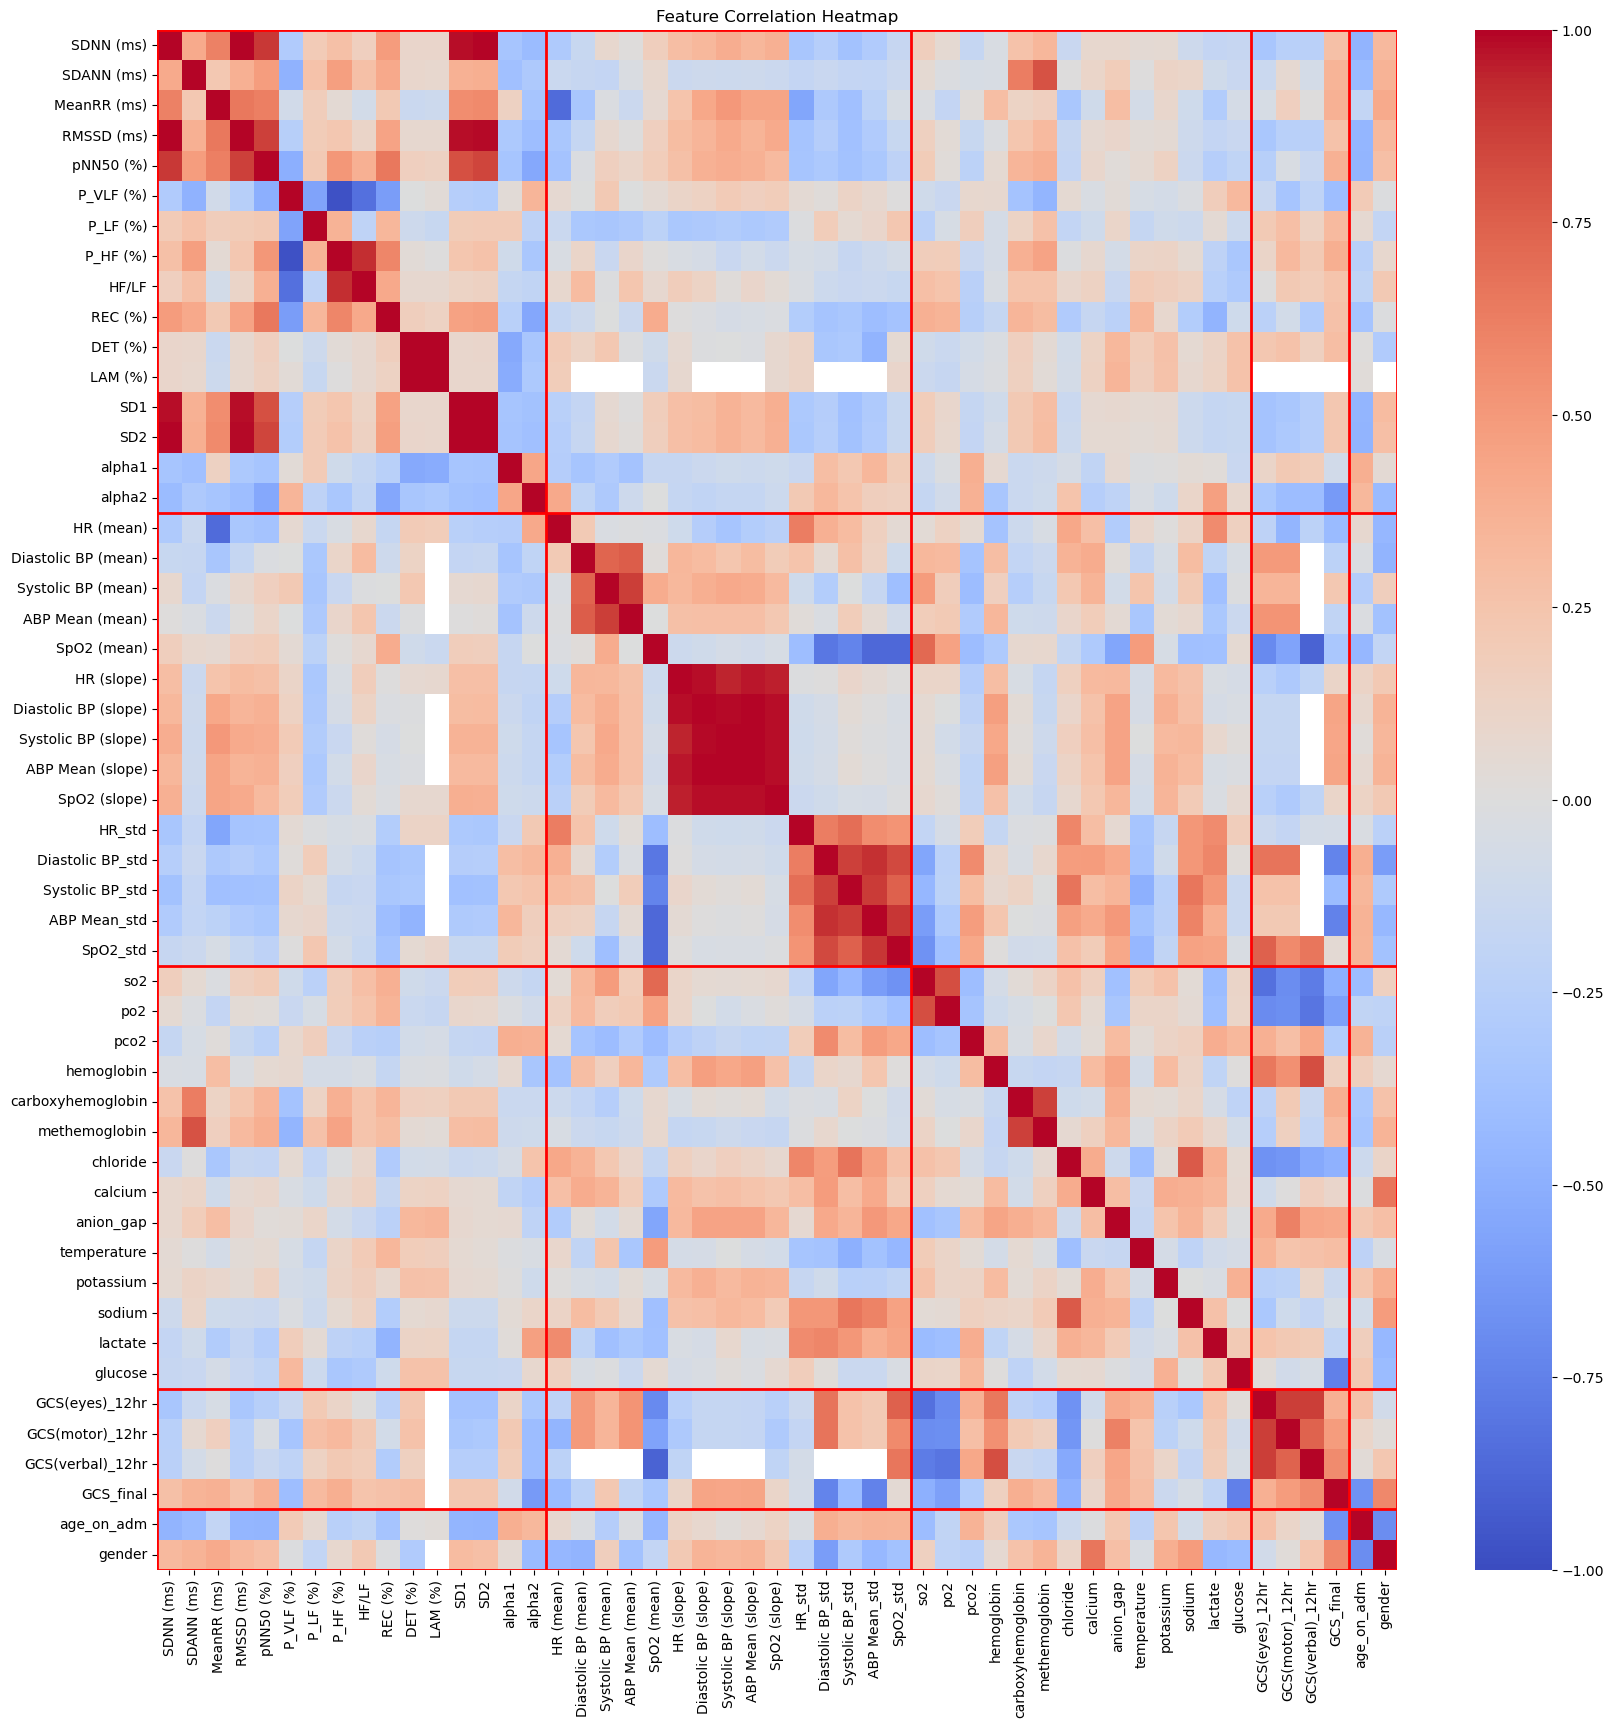

In [8]:
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

# Load and preprocess data
# Merge dataframes
merged_df = hrv.merge(vital, on='patientid', how='inner')
merged_df = merged_df.merge(lab, on='patientid', how='inner')
merged_df = merged_df.merge(gcs, on='patientid', how='inner')
merged_df = merged_df.merge(age, on='patientid', how='inner')
metrics = ['SDNN (ms)', 'SDANN (ms)', 'MeanRR (ms)', 'RMSSD (ms)', 'pNN50 (%)', 'P_VLF (%)','P_LF (%)','P_HF (%)','HF/LF', 'REC (%)','DET (%)','LAM (%)','SD1', 'SD2', 'alpha1' ,'alpha2',
          'HR (mean)','Diastolic BP (mean)','Systolic BP (mean)','ABP Mean (mean)','SpO2 (mean)','HR (slope)','Diastolic BP (slope)','Systolic BP (slope)','ABP Mean (slope)','SpO2 (slope)','HR_std','Diastolic BP_std','Systolic BP_std','ABP Mean_std','SpO2_std',
          'so2','po2','pco2','hemoglobin','carboxyhemoglobin', 'methemoglobin','chloride','calcium','anion_gap','temperature','potassium','sodium','lactate','glucose',
          'GCS(eyes)_12hr','GCS(motor)_12hr','GCS(verbal)_12hr','GCS_final',
          'age_on_adm','gender']

# Calculate correlation matrix
correlation_matrix = merged_df[metrics].corr()
plt.figure(figsize=(20, 20))
# Visualize correlation matrix as heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)


group_boundaries = [0, 16, 31, 45, 49, 51]

# Add group separation lines
for boundary in group_boundaries:
    plt.axhline(y=boundary, color='r', linewidth=2)
    plt.axvline(x=boundary, color='r', linewidth=2)
    
    
#plt.savefig(f'heatmap.png', dpi=100, bbox_inches='tight')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
merged_ = merged_df.drop(columns=['patientid'])

In [10]:
merged_

,SDNN (ms),SDANN (ms),MeanRR (ms),RMSSD (ms),pNN50 (%),P_VLF (s^2/Hz),P_LF (s^2/Hz),P_HF (s^2/Hz),P_VLF (%),P_LF (%),...,GCS(eyes)_final,GCS(motor)_final,GCS(verbal)_final,final from add,Total_add,Total_12hr,GCS_final,age_on_adm,gender,los
0,1327.07,6001.59,282.09,1356.91,0.76,3309.843,3095.212,7033.506,24.629,23.032,...,4.0,6.0,5.0,70.0,13.0,12.0,15.0,24,1.0,68
1,1183.60,6141.06,161.35,1194.64,0.22,7982.744,7335.211,15792.172,25.660,23.578,...,4.0,6.0,4.0,362.0,NaN,3.0,14.0,20,1.0,355
2,14.62,14.43,179.30,179.98,0.00,0.004,0.000,0.000,100.000,0.000,...,4.0,6.0,1.0,165.0,NaN,3.0,11.0,42,1.0,157
3,3946.99,399.79,344.84,3962.83,1.02,268175.571,103890.174,113141.276,55.270,21.412,...,4.0,6.0,4.0,41.0,3.0,3.0,14.0,17,1.0,33
4,48.97,37.25,147.99,155.90,0.14,0.019,0.006,0.004,65.517,20.690,...,4.0,6.0,4.0,150.0,NaN,3.0,14.0,32,1.0,143
5,104.04,83.26,162.15,192.67,0.23,0.010,0.005,0.009,41.667,20.833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,NaN,520
6,35.89,28.07,161.70,165.64,0.08,0.023,0.008,0.009,57.500,20.000,...,4.0,6.0,5.0,38.0,3.0,13.0,15.0,51,0.0,29
7,14.92,11.45,145.60,146.38,0.07,6361.963,3199.117,12868.847,28.364,14.263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,NaN,275
8,690.08,750.26,205.08,719.98,0.36,95.674,94.327,266.207,20.972,20.676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,43
9,40.34,28.97,244.92,248.25,0.07,0.089,0.023,0.022,66.418,17.164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,44


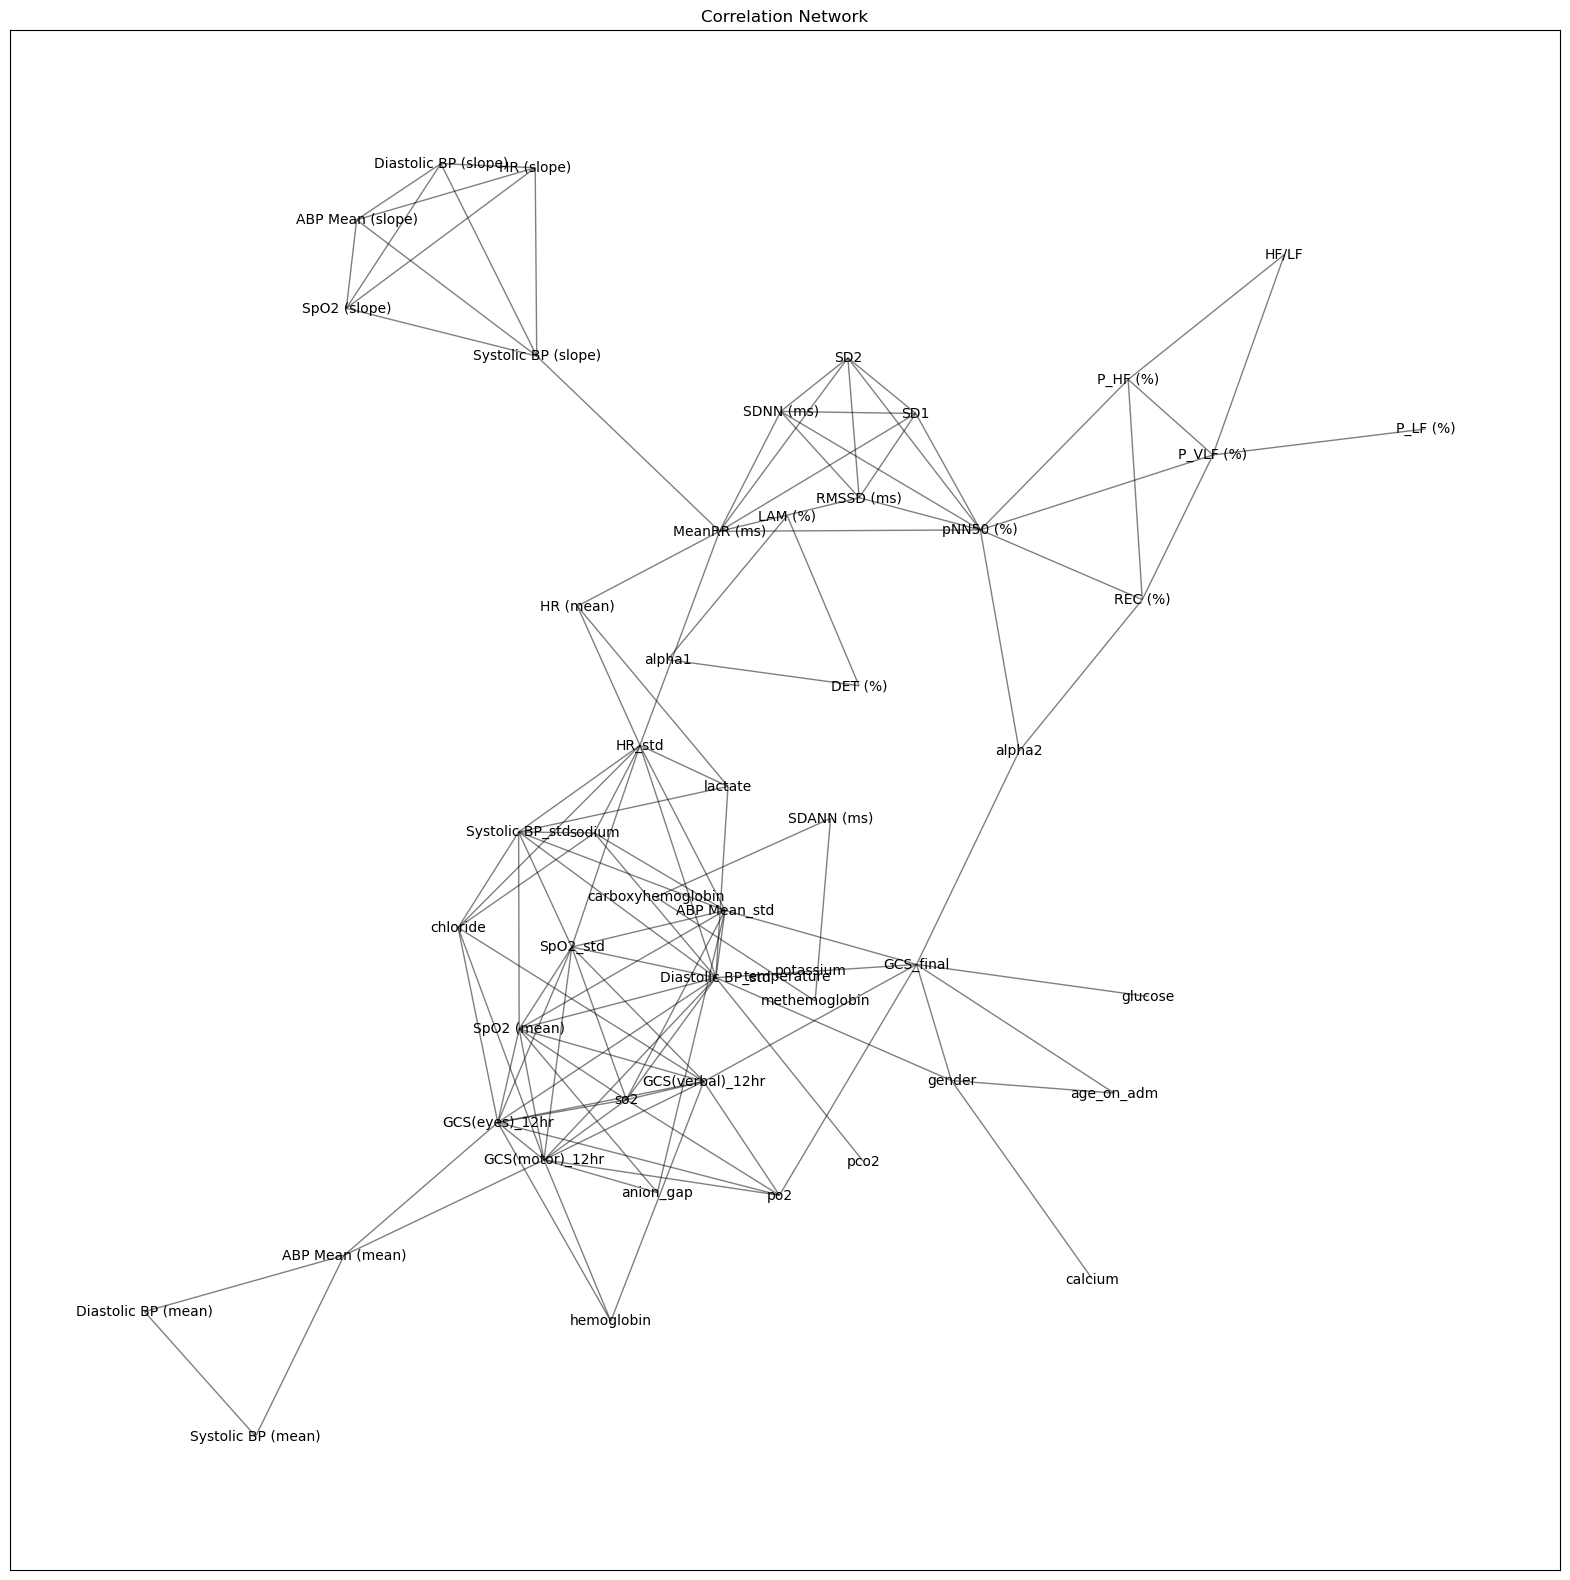

In [11]:
G = nx.Graph()

feature_sets = pd.DataFrame(index=correlation_matrix.columns)
feature_sets['Set'] = 'Other'
feature_sets.loc[feature_sets.index.isin(hrv.columns), 'Set'] = 'hrv'
feature_sets.loc[feature_sets.index.isin(vital.columns), 'Set'] = 'vital'
feature_sets.loc[feature_sets.index.isin(lab.columns), 'Set'] = 'lab'
feature_sets.loc[feature_sets.index.isin(gcs.columns), 'Set'] = 'gcs'
feature_sets.loc[feature_sets.index.isin(age.columns), 'Set'] = 'age'

# Create a color mapping for the sets
set_colors = {'hrv': 'blue', 'vital': 'green', 'lab': 'red', 'gcs': 'gray', 'age':'yellow'}
node_colors = [set_colors[feature_sets.loc[node]['Set']] for node in G.nodes]

# Add nodes (features)
for feature in correlation_matrix.columns:
    G.add_node(feature)

# Add edges (significant correlations)
threshold = 0.5  # Adjust this threshold as needed
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j])

# Visualize network with different node colors
plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(G)  # Layout algorithm
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Correlation Network")
#plt.savefig(f'corre_network.png', dpi=100, bbox_inches='tight')
plt.show()

In [12]:
!pip install torch torchvision torch-geometric
clear_output(wait=True)
print('Done')

Done


In [13]:
#!pip install community
!pip install python-louvain
clear_output(wait=True)
print('Done')

Done


In [14]:
mer_df = pd.read_csv("s3://hrv-and-others-relationship/features/trauma_final_features/merged_df_flitered_new.csv")

In [15]:
merged_ = mer_df.drop(columns=['patientid'])

In [16]:
!pip install torch_geometric
clear_output(wait=True)
print('Done')

Done


In [17]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.data import Data, DataLoader, Dataset

***New method***

In [18]:
G = nx.Graph()

metrics = ['SDNN (ms)', 'SDANN (ms)', 'MeanRR (ms)', 'RMSSD (ms)', 'pNN50 (%)', 'P_VLF (%)','P_LF (%)','P_HF (%)','HF/LF', 'REC (%)','DET (%)','LAM (%)','SD1', 'SD2', 'alpha1' ,'alpha2',
          'HR (mean)','Diastolic BP (mean)','Systolic BP (mean)','ABP Mean (mean)','SpO2 (mean)','HR (slope)','Diastolic BP (slope)','Systolic BP (slope)','ABP Mean (slope)','SpO2 (slope)','HR_std','Diastolic BP_std','Systolic BP_std','ABP Mean_std','SpO2_std',
          'so2','po2','pco2','hemoglobin','carboxyhemoglobin', 'methemoglobin','chloride','calcium','anion_gap','temperature','potassium','sodium','lactate','glucose',
          'GCS(eyes)_12hr','GCS(motor)_12hr','GCS(verbal)_12hr','GCS_final',
          'age_on_adm','gender']
# Define the subsets and their colors
set_colors = {'hrv': 'blue', 'vital': 'green', 'lab': 'red', 'gcs': 'gray', 'age': 'yellow'}

# Initialize a dictionary to store community assignments for each subset
community_assignments = {subset: {} for subset in set_colors.keys()}

# Add nodes (features) to the graph and assign colors
for feature in merged_[metrics]:
    subset = feature_sets.loc[feature.strip()]['Set']
    G.add_node(feature, color=set_colors[subset])

    

correlation_matrix = merged_[metrics].corr()
# Add edges (significant correlations) with a weight of 1
threshold = 0.5  # Adjust this threshold as needed
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j], weight=1)

# Create a mapping from node names to integers
node_to_index = {node: i for i, node in enumerate(G.nodes)}

# Map the nodes to integers in the edge list
edge_index = torch.tensor([(node_to_index[u], node_to_index[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()


# Convert the adjacency matrix to a dense PyTorch tensor
adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix = torch.tensor(adjacency_matrix.todense(), dtype=torch.float)

# Print adjacency matrix and edge indices
print("Edge Index Shape:", edge_index.shape)
print("Edge Index Content:", edge_index)
print("Adjacency Matrix:")
print(adjacency_matrix)
print("Edge Indices:")
print(edge_index)


Edge Index Shape: torch.Size([2, 119])
Edge Index Content: tensor([[ 0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  4,
          4,  4,  4,  4,  4,  5,  5,  5,  5,  7,  7,  9, 10, 10, 11, 12, 15, 16,
         16, 17, 17, 18, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
         21, 22, 22, 22, 23, 23, 24, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30,
         30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 34, 34, 34, 35, 37, 37, 37,
         37, 38, 39, 44, 45, 45, 46, 47, 48, 48, 49],
        [ 2,  3,  4, 12, 13, 35, 36,  3,  4, 12, 13, 16, 23, 26,  4, 12, 13,  5,
          7,  9, 12, 13, 15,  6,  7,  8,  9,  8,  9, 15, 11, 14, 14, 13, 48, 26,
         43, 18, 19, 19, 45, 46, 27, 28, 29, 30, 31, 39, 45, 46, 47, 22, 23, 24,
         25, 23, 24, 25, 24, 25, 25, 27, 28, 29, 30, 37, 42, 43, 28, 29, 30, 31,
         33, 42, 43, 45, 46, 48, 50, 29, 30, 37, 42, 43, 30, 31, 39, 42, 48, 

/tmp/ipykernel_21190/252663105.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


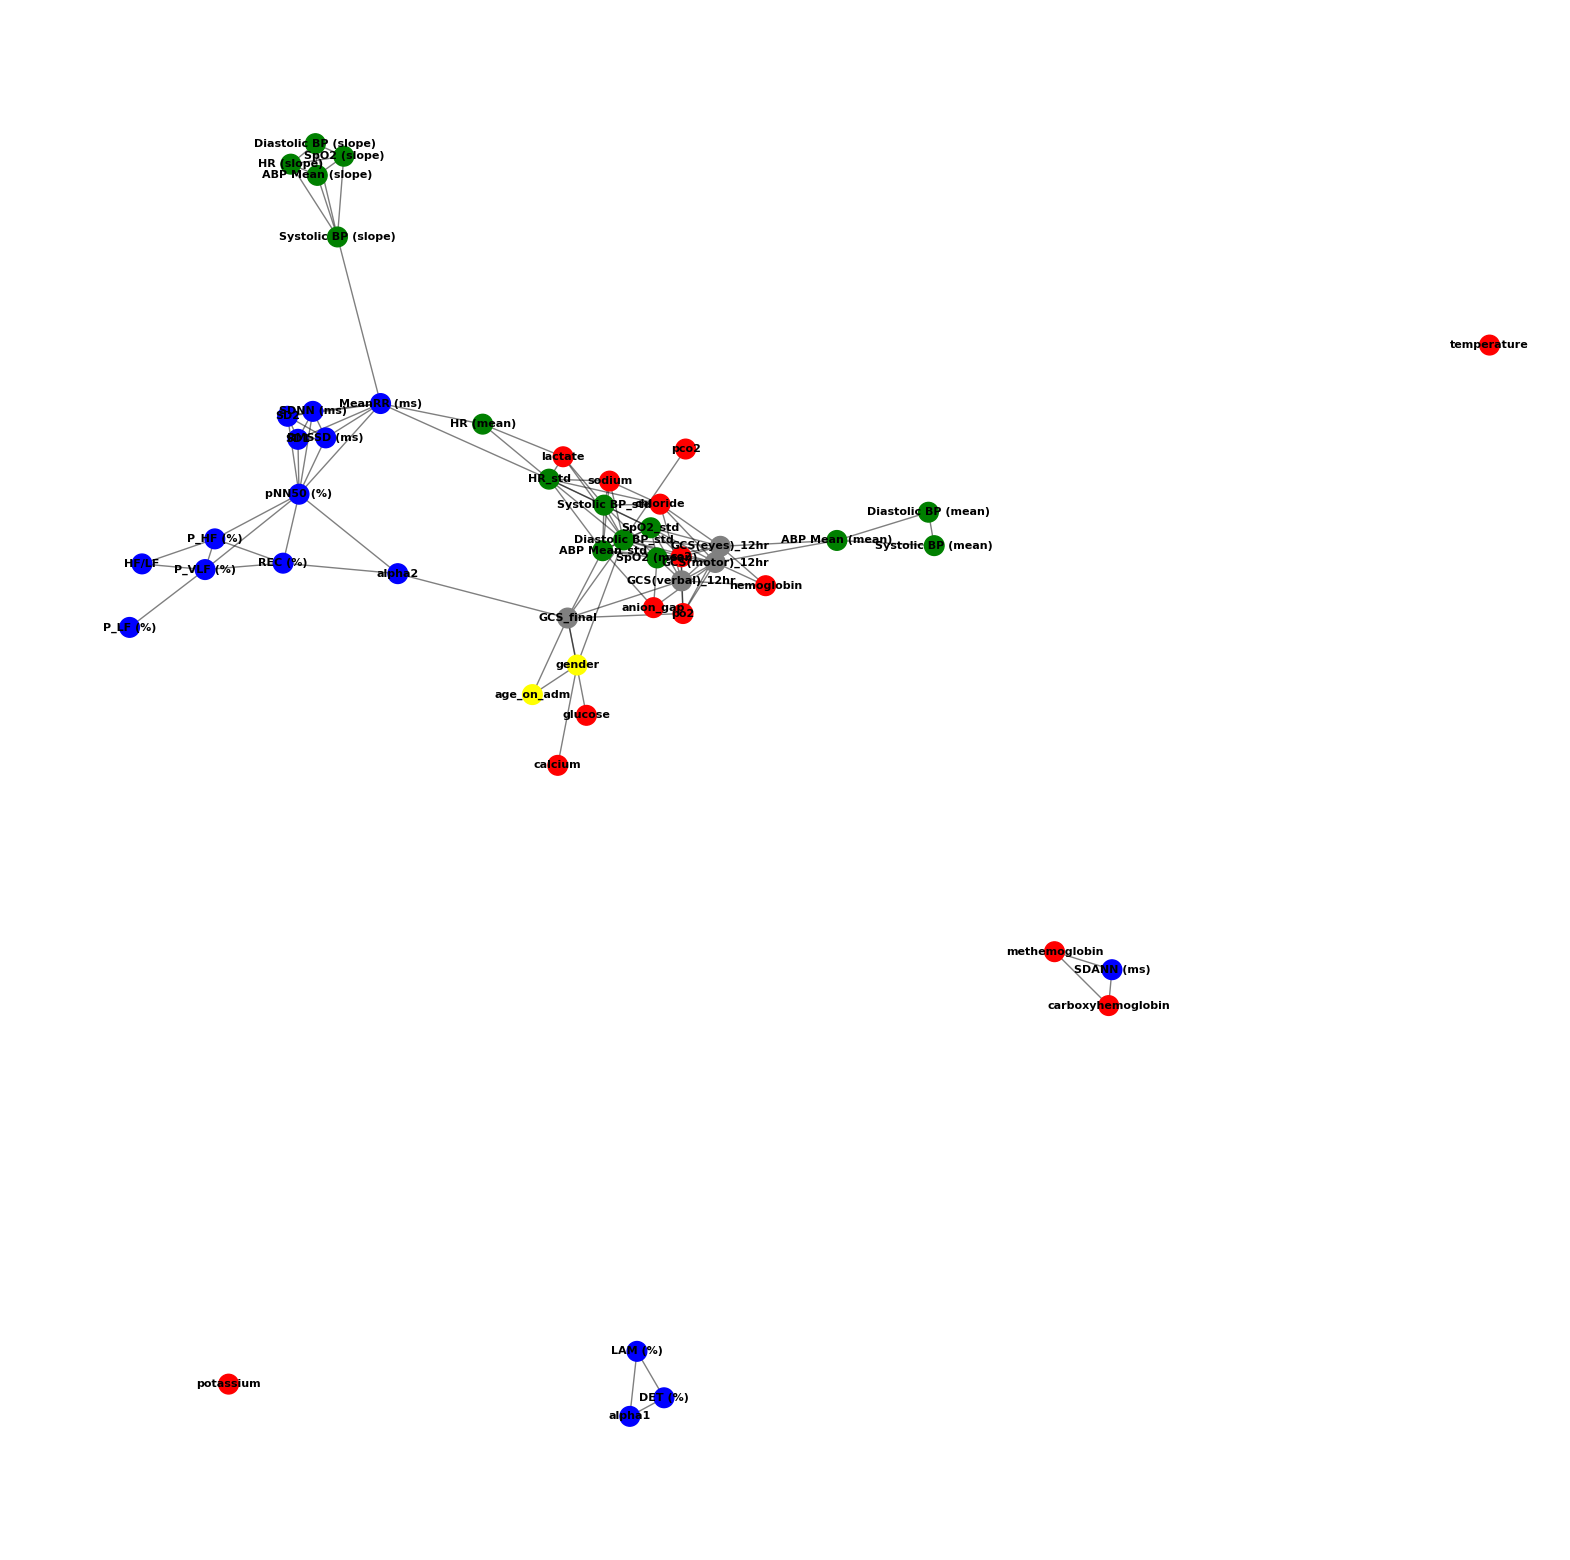

In [19]:
import matplotlib.pyplot as plt

# Compute the layout positions of the nodes using a force-directed layout algorithm
pos = nx.spring_layout(G, seed=42)  # You can choose different layout algorithms as well

# Define node colors based on subsets
node_colors = [node[1]['color'] for node in G.nodes(data=True)]
plt.figure(figsize=(20, 20))
# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw node labels if needed
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_weight='bold')
#plt.savefig("gnn_grapg.png") 
plt.axis('off')
plt.show()


**Inter-Community Edge Analysis:**

In [20]:
# Initialize a dictionary to hold edge counts between communities
edge_counts = {community: {other_community: 0 for other_community in set_colors.keys()} for community in set_colors.keys()}

# Count edges between communities
for u, v in G.edges():
    community_u = feature_sets.loc[u, 'Set']
    community_v = feature_sets.loc[v, 'Set']
    edge_counts[community_u][community_v] += 1
    edge_counts[community_v][community_u] += 1  # if the graph is undirected

# Print edge counts between communities
print("Edge counts between communities:")
print(edge_counts)


Edge counts between communities:
{'hrv': {'hrv': 58, 'vital': 3, 'lab': 2, 'gcs': 1, 'age': 0}, 'vital': {'hrv': 3, 'vital': 56, 'lab': 17, 'gcs': 12, 'age': 1}, 'lab': {'hrv': 2, 'vital': 17, 'lab': 6, 'gcs': 15, 'age': 1}, 'gcs': {'hrv': 1, 'vital': 12, 'lab': 15, 'gcs': 8, 'age': 2}, 'age': {'hrv': 0, 'vital': 1, 'lab': 1, 'gcs': 2, 'age': 2}}


**Community Connectivity Metrics:**

In [21]:
betweenness_centrality = nx.betweenness_centrality(G)

# You can print or analyze this dictionary as needed
print("Betweenness Centrality of each node:")
print(betweenness_centrality)

Betweenness Centrality of each node:
{'SDNN (ms)': 0.0, 'SDANN (ms)': 0.0, 'MeanRR (ms)': 0.26761616161616164, 'RMSSD (ms)': 0.0, 'pNN50 (%)': 0.13752528197426164, 'P_VLF (%)': 0.04938775510204082, 'P_LF (%)': 0.0, 'P_HF (%)': 0.015918367346938776, 'HF/LF': 0.0, 'REC (%)': 0.026656771799628956, 'DET (%)': 0.0, 'LAM (%)': 0.0, 'SD1': 0.0, 'SD2': 0.0, 'alpha1': 0.0, 'alpha2': 0.10157723002620961, 'HR (mean)': 0.006394557823129252, 'Diastolic BP (mean)': 0.0, 'Systolic BP (mean)': 0.0, 'ABP Mean (mean)': 0.0653061224489796, 'SpO2 (mean)': 0.0066290684105810155, 'HR (slope)': 0.0, 'Diastolic BP (slope)': 0.0, 'Systolic BP (slope)': 0.12408163265306123, 'ABP Mean (slope)': 0.0, 'SpO2 (slope)': 0.0, 'HR_std': 0.22225666716903214, 'Diastolic BP_std': 0.15190855802860606, 'Systolic BP_std': 0.006801837618164149, 'ABP Mean_std': 0.045290484092404874, 'SpO2_std': 0.038298255432709205, 'so2': 0.004882426363818921, 'po2': 0.012460876991489239, 'pco2': 0.0, 'hemoglobin': 0.0, 'carboxyhemoglobin': 0

In [22]:
edge_betweenness = nx.edge_betweenness_centrality(G)

# This dictionary can be analyzed to find important edges between communities
print("Edge Betweenness:")
print(edge_betweenness)

Edge Betweenness:
{('SDNN (ms)', 'MeanRR (ms)'): 0.02082788671023965, ('SDNN (ms)', 'RMSSD (ms)'): 0.000784313725490196, ('SDNN (ms)', 'pNN50 (%)'): 0.009760348583877995, ('SDNN (ms)', 'SD1'): 0.000784313725490196, ('SDNN (ms)', 'SD2'): 0.000784313725490196, ('SDANN (ms)', 'carboxyhemoglobin'): 0.000784313725490196, ('SDANN (ms)', 'methemoglobin'): 0.000784313725490196, ('MeanRR (ms)', 'RMSSD (ms)'): 0.02082788671023965, ('MeanRR (ms)', 'pNN50 (%)'): 0.08512638994991938, ('MeanRR (ms)', 'SD1'): 0.02082788671023965, ('MeanRR (ms)', 'SD2'): 0.02082788671023965, ('MeanRR (ms)', 'HR (mean)'): 0.019477124183006535, ('MeanRR (ms)', 'Systolic BP (slope)'): 0.14901960784313725, ('MeanRR (ms)', 'HR_std'): 0.21024932801403381, ('RMSSD (ms)', 'pNN50 (%)'): 0.009760348583877995, ('RMSSD (ms)', 'SD1'): 0.000784313725490196, ('RMSSD (ms)', 'SD2'): 0.000784313725490196, ('pNN50 (%)', 'P_VLF (%)'): 0.05850267379679144, ('pNN50 (%)', 'P_HF (%)'): 0.03510160427807486, ('pNN50 (%)', 'REC (%)'): 0.0118300

In [23]:
betweenness_centrality = nx.betweenness_centrality(G)

# Identifying key nodes in each community
for community in set_colors.keys():
    print(f"Key nodes in {community} community based on betweenness centrality:")
    community_nodes = [node for node in G.nodes() if feature_sets.loc[node, 'Set'] == community]
    community_centralities = {node: betweenness_centrality[node] for node in community_nodes}
    # Sort the nodes in the community by their betweenness centrality
    sorted_community_nodes = sorted(community_centralities, key=community_centralities.get, reverse=True)
    # Display top nodes
    print(sorted_community_nodes[:5])  # Top 5 nodes, adjust as needed


Key nodes in hrv community based on betweenness centrality:
['MeanRR (ms)', 'pNN50 (%)', 'alpha2', 'P_VLF (%)', 'REC (%)']
Key nodes in vital community based on betweenness centrality:
['HR_std', 'Diastolic BP_std', 'Systolic BP (slope)', 'ABP Mean (mean)', 'ABP Mean_std']
Key nodes in lab community based on betweenness centrality:
['chloride', 'po2', 'so2', 'lactate', 'sodium']
Key nodes in gcs community based on betweenness centrality:
['GCS_final', 'GCS(motor)_12hr', 'GCS(eyes)_12hr', 'GCS(verbal)_12hr']
Key nodes in age community based on betweenness centrality:
['gender', 'age_on_adm']


In [24]:
edge_betweenness = nx.edge_betweenness_centrality(G)

# Identifying important edges between communities
important_edges = []
for (u, v), centrality in edge_betweenness.items():
    if feature_sets.loc[u, 'Set'] != feature_sets.loc[v, 'Set']:  # Edge connecting different communities
        important_edges.append(((u, v), centrality))

# Sort and display the most important edges
important_edges.sort(key=lambda x: x[1], reverse=True)
print("Most important edges between different communities:")
print(important_edges[:5])  # Top 5 edges, adjust as needed


Most important edges between different communities:
[(('MeanRR (ms)', 'HR_std'), 0.21024932801403381), (('MeanRR (ms)', 'Systolic BP (slope)'), 0.14901960784313725), (('alpha2', 'GCS_final'), 0.1169402144696262), (('ABP Mean (mean)', 'GCS(motor)_12hr'), 0.048366013071895426), (('ABP Mean (mean)', 'GCS(eyes)_12hr'), 0.0457516339869281)]


**Subgraph Analysis for Each Community Pair:**

In [25]:
# Creating a subgraph for 'hrv' and 'vital' communities
hrv_vital_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'hrv' and feature_sets.loc[v, 'Set'] == 'vital']
hrv_vital_subgraph = G.edge_subgraph(hrv_vital_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in hrv-vital subgraph:", hrv_vital_subgraph.number_of_edges())

# Creating a subgraph for 'hrv' and 'vital' communities
hrv_lab_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'hrv' and feature_sets.loc[v, 'Set'] == 'lab']
hrv_lab_subgraph = G.edge_subgraph(hrv_lab_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in hrv-lab subgraph:", hrv_lab_subgraph.number_of_edges())

# Creating a subgraph for 'hrv' and 'vital' communities
hrv_gcs_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'hrv' and feature_sets.loc[v, 'Set'] == 'gcs']
hrv_gcs_subgraph = G.edge_subgraph(hrv_gcs_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in hrv-gcs subgraph:", hrv_gcs_subgraph.number_of_edges())

# Creating a subgraph for 'hrv' and 'vital' communities
hrv_age_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'hrv' and feature_sets.loc[v, 'Set'] == 'age']
hrv_age_subgraph = G.edge_subgraph(hrv_age_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in hrv-age subgraph:", hrv_age_subgraph.number_of_edges())

# Creating a subgraph for 'hrv' and 'vital' communities
vital_lab_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'vital' and feature_sets.loc[v, 'Set'] == 'lab']
vital_lab_subgraph = G.edge_subgraph(vital_lab_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in vital_lab subgraph:", vital_lab_subgraph.number_of_edges())

vital_gcs_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'vital' and feature_sets.loc[v, 'Set'] == 'gcs']
vital_gcs_subgraph = G.edge_subgraph(vital_gcs_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in vital_gcs subgraph:", vital_gcs_subgraph.number_of_edges())

vital_age_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'vital' and feature_sets.loc[v, 'Set'] == 'age']
vital_age_subgraph = G.edge_subgraph(vital_age_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in vital_age subgraph:", vital_age_subgraph.number_of_edges())

lab_gcs_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'lab' and feature_sets.loc[v, 'Set'] == 'gcs']
lab_gcs_subgraph = G.edge_subgraph(lab_gcs_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in lab_gcs subgraph:", lab_gcs_subgraph.number_of_edges())


lab_age_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'lab' and feature_sets.loc[v, 'Set'] == 'age']
lab_age_subgraph = G.edge_subgraph(lab_age_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in lab_age subgraph:", lab_age_subgraph.number_of_edges())

gcs_age_edges = [(u, v) for u, v in G.edges() if feature_sets.loc[u, 'Set'] == 'gcs' and feature_sets.loc[v, 'Set'] == 'age']
gcs_age_subgraph = G.edge_subgraph(gcs_age_edges)
# Analyze the subgraph (e.g., number of edges, nodes, etc.)
print("Number of edges in gcs_age subgraph:", gcs_age_subgraph.number_of_edges())

Number of edges in hrv-vital subgraph: 3
Number of edges in hrv-lab subgraph: 2
Number of edges in hrv-gcs subgraph: 1
Number of edges in hrv-age subgraph: 0
Number of edges in vital_lab subgraph: 17
Number of edges in vital_gcs subgraph: 12
Number of edges in vital_age subgraph: 1
Number of edges in lab_gcs subgraph: 15
Number of edges in lab_age subgraph: 1
Number of edges in gcs_age subgraph: 2


In [27]:
def calculate_density(num_edges, num_nodes_group1, num_nodes_group2):
    total_possible_edges = num_nodes_group1 * num_nodes_group2  # For bipartite subgraph
    density = num_edges / total_possible_edges
    return density

# Example: Assuming you have the number of nodes for each group
num_nodes_hrv = len([node for node in G.nodes() if feature_sets.loc[node, 'Set'] == 'hrv'])
num_nodes_vital = len([node for node in G.nodes() if feature_sets.loc[node, 'Set'] == 'vital'])
num_nodes_lab = len([node for node in G.nodes() if feature_sets.loc[node, 'Set'] == 'lab'])
num_nodes_gcs = len([node for node in G.nodes() if feature_sets.loc[node, 'Set'] == 'gcs'])
num_nodes_age = len([node for node in G.nodes() if feature_sets.loc[node, 'Set'] == 'age'])

# ...and so on for 'lab', 'gcs', 'age'

# Calculate densities
density_hrv_vital = calculate_density(3, num_nodes_hrv, num_nodes_vital)
density_hrv_lab = calculate_density(2, num_nodes_hrv, num_nodes_lab)
density_hrv_gcs = calculate_density(1, num_nodes_hrv, num_nodes_gcs)
density_hrv_age = calculate_density(0, num_nodes_hrv, num_nodes_age)
density_vital_lab = calculate_density(17, num_nodes_vital, num_nodes_lab)
density_vital_gcs = calculate_density(12, num_nodes_vital, num_nodes_gcs)
density_vital_age = calculate_density(1, num_nodes_vital, num_nodes_age)
density_lab_gcs = calculate_density(15, num_nodes_lab, num_nodes_gcs)
density_lab_age = calculate_density(1, num_nodes_lab, num_nodes_age)
density_gcs_age = calculate_density(2, num_nodes_gcs, num_nodes_age)
# ...and so on for other group combinations

# Print densities
print("Density for HRV-Vital subgraph:", density_hrv_vital)
print("Density for HRV-Lab subgraph:", density_hrv_lab)
print("Density for HRV-Gcs subgraph:", density_hrv_gcs)
print("Density for HRV-age subgraph:", density_hrv_age)
print("Density for Vital-Lab subgraph:", density_vital_lab)
print("Density for Vital-GCS subgraph:", density_vital_gcs)
print("Density for Vital-age subgraph:", density_vital_age)
print("Density for lab-GCS subgraph:", density_lab_gcs)
print("Density for Lab-Age subgraph:", density_lab_age)
print("Density for GCS-Age subgraph:", density_gcs_age)
# ...and so on for other group combinations


Density for HRV-Vital subgraph: 0.0125
Density for HRV-Lab subgraph: 0.008928571428571428
Density for HRV-Gcs subgraph: 0.015625
Density for HRV-age subgraph: 0.0
Density for Vital-Lab subgraph: 0.08095238095238096
Density for Vital-GCS subgraph: 0.2
Density for Vital-age subgraph: 0.03333333333333333
Density for lab-GCS subgraph: 0.26785714285714285
Density for Lab-Age subgraph: 0.03571428571428571
Density for GCS-Age subgraph: 0.25


In [28]:
import numpy as np

# Density values
densities = [0.0125, 0.0089, 0.0156, 0.0, 0.081, 0.2, 0.0333, 0.2679, 0.0357, 0.25]

# Normalize densities to a scale, e.g., 0-10
max_density = max(densities)
normalized_densities = [density / max_density * 10 for density in densities]


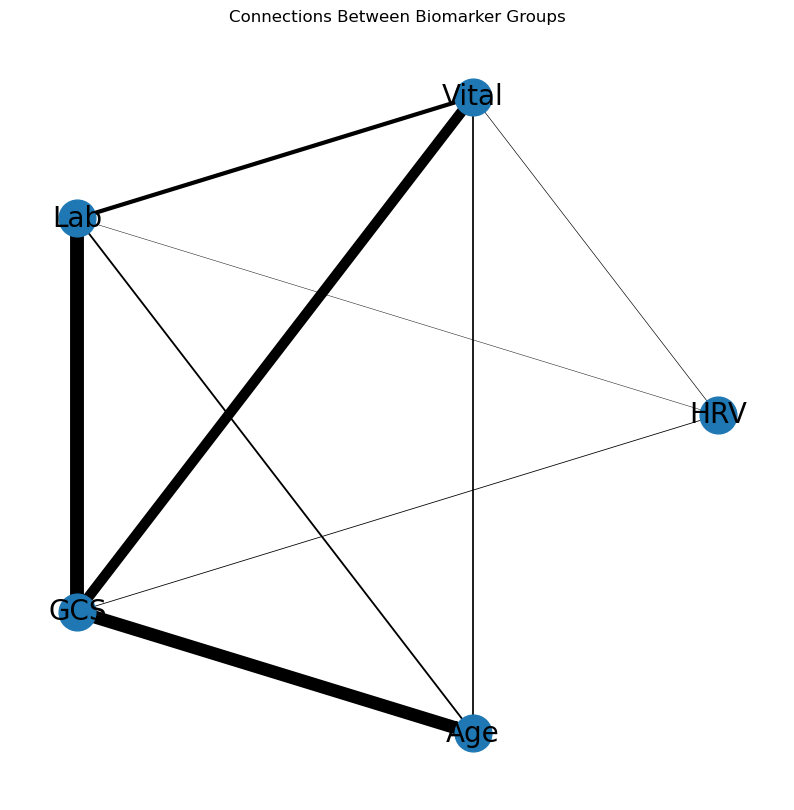

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes
G.add_node("HRV")
G.add_node("Vital")
G.add_node("Lab")
G.add_node("GCS")
G.add_node("Age")

# Add edges with normalized densities as weights
G.add_edge("HRV", "Vital", weight=normalized_densities[0])
G.add_edge("HRV", "Lab", weight=normalized_densities[1])
G.add_edge("HRV", "GCS", weight=normalized_densities[2])
G.add_edge("HRV", "Age", weight=normalized_densities[3])
G.add_edge("Vital", "Lab", weight=normalized_densities[4])
G.add_edge("Vital", "GCS", weight=normalized_densities[5])
G.add_edge("Vital", "Age", weight=normalized_densities[6])
G.add_edge("Lab", "GCS", weight=normalized_densities[7])
G.add_edge("Lab", "Age", weight=normalized_densities[8])
G.add_edge("GCS", "Age", weight=normalized_densities[9])
# ... Add other edges similarly

# Draw the network
pos = nx.circular_layout(G)  # Positioning the nodes in a circle
plt.figure(figsize=(10, 10))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# Draw edges with varying width based on weight
for (u, v, wt) in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=wt['weight'])

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=20)

plt.title("Connections Between Biomarker Groups")
plt.axis('off')
plt.savefig(f'group_connection.png', dpi=100, bbox_inches='tight')
plt.show()


In [30]:
normalized_densities

[0.4665920119447555,
 0.3322135125046659,
 0.5823068309070547,
 0.0,
 3.0235162374020152,
 7.465472191116088,
 1.2430011198208286,
 10.0,
 1.3325867861142218,
 9.33184023889511]

**Clustering Coefficient**

In [31]:
clustering_coefficients = nx.clustering(G)

# Print clustering coefficient for each node
print("Clustering Coefficients:")
print(clustering_coefficients)

# Calculate and print the average clustering coefficient
average_clustering = nx.average_clustering(G)
print("Average Clustering Coefficient:", average_clustering)


Clustering Coefficients:
{'HRV': 1.0, 'Vital': 1.0, 'Lab': 1.0, 'GCS': 1.0, 'Age': 1.0}
Average Clustering Coefficient: 1.0
